# Stacking Multiple Classification Models

__________________________
**Tags:** *Machine Learning*, *Model Stacking*, *Classification*, *Predictive Analysis*

**Models**: *LinearSVC*, *KNeighborsClassifier*, *DecisionTreeClassifier*, *RandomForestClassifier*

**Python:** *Scikit-Learn*, *Pandas*, *Matplotlib*
__________________________

__________________________
**Scenario:** The Covertype dataset is a large collection of environmental data used for classifying forest cover types based on various geographical and ecological attributes. Each instance represents a 30x30 meter cell in a forest. We will build three models and use a fourth model in order to improve the final model's accuracy.


**Goal:** The goal of the dataset is to predict one of seven forest cover types, which represent different tree species.


**Dataset:** The Cover Type Dataset is provided by the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/31/covertype) through Scikit Learn (see [Scikit Learn User Guide](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.fetch_covtype.html)). It consists of 54 numerical features and has already been cleaned.
__________________________

__________________________
## Contents

1. **Data Preprocessing**
<p> </p>
2. **Model Building**
<p> </p>
3. **Stacking estimators**
__________________________

### Relevant packages used throughout this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay

### Reproducibility

According to the [Scikit Learn User Guide](https://scikit-learn.org/stable/common_pitfalls.html#general-recommendations), the recommended way to control random instances is to create an RNG variable at the top and pass it to any object with a *random_state* parameter.

In [2]:
rng = np.random.RandomState(0)

## 1. Data Preprocessing
### Loading Data

We are going to utilize one of Scikit Learn's provided data sets, accessible [here](https://archive.ics.uci.edu/dataset/31/covertype).

In [3]:
df = fetch_covtype(as_frame=True)
X, y = df['data'], df['target']

X.shape

(581012, 54)

### Splitting into Training and Test Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

### Data Structure

In [5]:
X_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
279523,2444.0,4.0,15.0,469.0,251.0,1018.0,199.0,210.0,147.0,997.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562159,3355.0,96.0,23.0,713.0,63.0,1026.0,249.0,200.0,67.0,5491.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
83158,2988.0,329.0,4.0,120.0,10.0,3130.0,210.0,235.0,163.0,6292.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57372,2827.0,62.0,13.0,180.0,8.0,2687.0,230.0,214.0,114.0,3824.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
452735,3042.0,344.0,10.0,242.0,52.0,1176.0,199.0,224.0,163.0,1273.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preparing Data for Algorithms

The following pipeline will take care of all numerical (that is, all) attributes by first imputing a feature's median to any missing values and then scale them accordingly.

In [6]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             StandardScaler()
                            )

## 2. Model Building

### Support Vector Machine Classifier

In [7]:
svm_clf = make_pipeline(num_pipeline,
                      LinearSVC(C=100, dual="auto", random_state=rng))
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('standardscaler', StandardScaler())])),
                ('linearsvc',
                 LinearSVC(C=100, dual='auto',
                           random_state=RandomState(MT19937) at 0x7B9F2F94D740))])

In [8]:
y_svm = svm_clf.predict(X_test)

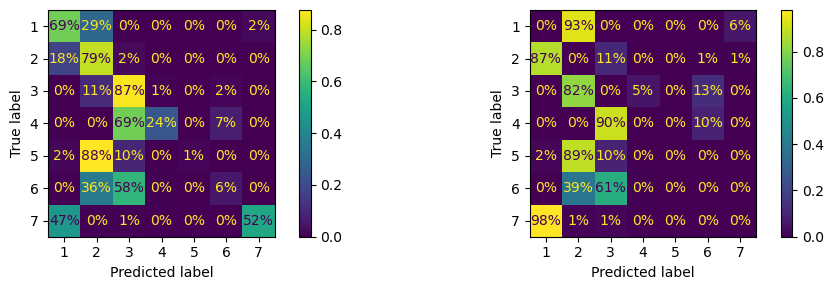

In [9]:
sample_weight_svm = (y_svm != y_test)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_svm, normalize="true", values_format=".0%", ax=ax1)
ConfusionMatrixDisplay.from_predictions(y_test, y_svm, sample_weight=sample_weight_svm, normalize="true", values_format=".0%", ax=ax2)
fig.tight_layout()

(In these diagrams, the second matrix ignores the main diagonal to better highlight what errors have been made.)

In [10]:
accuracy_svm = 1 - sum(sample_weight_svm)/len(sample_weight_svm)
accuracy_svm

0.7125547533196217

The computed accuracy for this classifier is 71.3%.

### KNearestNeighbors Classifier

In [11]:
knn_clf = make_pipeline(num_pipeline,
                      KNeighborsClassifier(n_neighbors=5))
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('standardscaler', StandardScaler())])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [12]:
y_knn = knn_clf.predict(X_test)

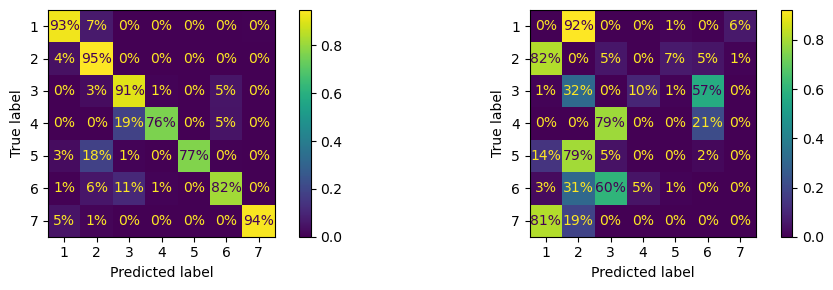

In [13]:
sample_weight_knn = (y_knn != y_test)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_knn, normalize="true", values_format=".0%", ax=ax1)
ConfusionMatrixDisplay.from_predictions(y_test, y_knn, sample_weight=sample_weight_knn, normalize="true", values_format=".0%", ax=ax2)
fig.tight_layout()

In [14]:
accuracy_knn = 1 - sum(sample_weight_knn)/len(sample_weight_knn)
accuracy_knn

0.9291154273125479

The computed accuracy for this classifier is 92.9%.

### Decision Tree

In [15]:
tree_clf = make_pipeline(num_pipeline,
                      DecisionTreeClassifier())
tree_clf.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('standardscaler', StandardScaler())])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [16]:
y_tree = tree_clf.predict(X_test)

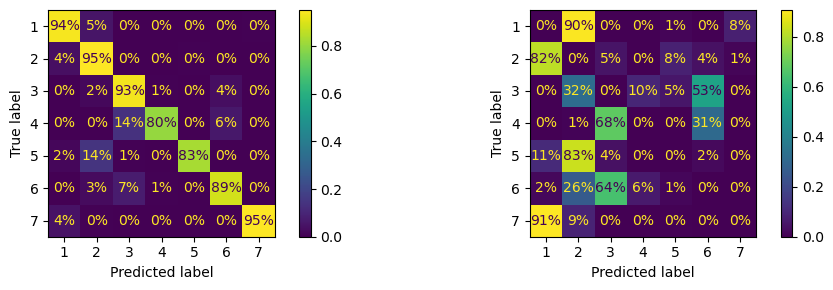

In [17]:
sample_weight_tree = (y_tree != y_test)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_tree, normalize="true", values_format=".0%", ax=ax1)
ConfusionMatrixDisplay.from_predictions(y_test, y_tree, sample_weight=sample_weight_tree, normalize="true", values_format=".0%", ax=ax2)
fig.tight_layout()

In [18]:
accuracy_tree = 1 - sum(sample_weight_tree)/len(sample_weight_tree)
accuracy_tree

0.9403629854650912

The computed accuracy for this classifier is 94.0%.

## 3. Stacking estimators

The fundamental idea of stacking is to combine multiple models into one superior model. The latter bases its decision on the predictions of the submodels and hopefully improves its overall accuracy.

In [19]:
stacking_clf = StackingClassifier(
                    estimators = [
                        ('SVM', svm_clf),
                        ('KNN', knn_clf),
                        ('TREE', tree_clf)
                                 ],
                    final_estimator=RandomForestClassifier(random_state=rng)
                )

stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('simpleimputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('standardscaler',
                                                                  StandardScaler())])),
                                                ('linearsvc',
                                                 LinearSVC(C=100, dual='auto',
                                                           random_state=RandomState(MT19937) at 0x7B9F2F94D740))])),
                               ('KNN',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('simpleimputer',
                                                                  SimpleImputer(...
                                                                  StandardScaler())])),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())])),
                               ('TREE',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('simpleimputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('standardscaler',
                                                                  StandardScaler())])),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier())]))],
                   final_estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7B9F2F94D740))

In [20]:
y_stacking = stacking_clf.predict(X_test)

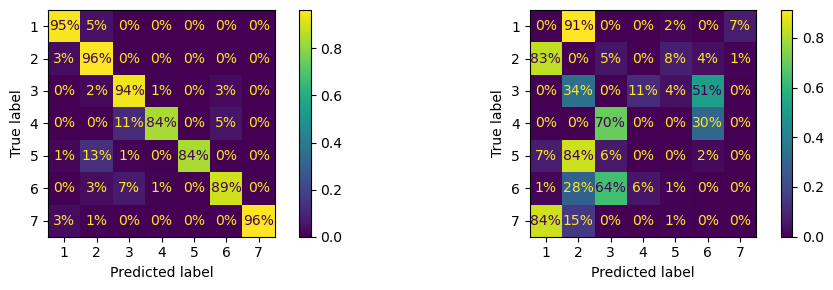

In [21]:
sample_weight_stacking = (y_stacking != y_test)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_stacking, normalize="true", values_format=".0%", ax=ax1)
ConfusionMatrixDisplay.from_predictions(y_test, y_stacking, sample_weight=sample_weight_stacking, normalize="true", values_format=".0%", ax=ax2)
fig.tight_layout()

In [22]:
accuracy_stacking = 1 - sum(sample_weight_stacking)/len(sample_weight_stacking)
accuracy_stacking

0.9517568393242859

The computed accuracy for this classifier is 95.2%. Nice! The final model further improved the accuracy in comparison to each submodel.